# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from relativeImp import relativeImp #key drivers package taken from <<https://pypi.org/project/relativeImp/>>
from sklearn.ensemble import RandomForestRegressor #randomforests package, to help triangulate on relative imp
import scipy.stats as stats #for ANOVA

# Data Ingest, Process, and Inspect

In [2]:
df = pd.read_csv('RWA CSV 2024.csv')

In [3]:
df.head(5) #inspect the data

,OrgID,Finished,Gender,AgeCat,@PF1_OrgSup_1,@PF1_OrgSup_2,@PF1_OrgSup_3,@PF2_Cult_1,@PF2_Cult_2,@PF2_Cult_3,...,PF6Growth,PF7RecRew,PF8AutInv,PF9WkLoad,PF10Engage,PF11WLB,PF12PsySafety,PF13OrgSafety,K6,DASS
0,1,0,Female,20-29,2,4,4,2,1,4,...,5.00,5.00,3.33,5.33,3.67,6.00,5.33,2.00,1.83,1.86
1,1,0,Female,40-49,6,6,6,6,6,6,...,6.00,5.00,6.00,6.00,6.00,5.67,5.67,4.67,1.83,2.00
2,1,0,Female,20-29,5,5,5,5,5,5,...,4.00,5.00,6.33,6.00,6.67,6.00,4.33,3.67,1.67,1.29
3,1,0,Female,60-69,6,4,6,5,5,5,...,4.00,4.00,4.33,5.67,4.67,3.33,3.00,3.67,2.17,2.43
4,1,0,Female,50-59,6,5,6,3,2,5,...,3.33,4.33,3.67,4.00,4.00,2.33,4.00,2.67,2.50,2.86


In [4]:
df.describe() #descriptives for all

,OrgID,Finished,@PF1_OrgSup_1,@PF1_OrgSup_2,@PF1_OrgSup_3,@PF2_Cult_1,@PF2_Cult_2,@PF2_Cult_3,@PF3_Ldshp_1,@PF3_Ldshp_2,...,PF6Growth,PF7RecRew,PF8AutInv,PF9WkLoad,PF10Engage,PF11WLB,PF12PsySafety,PF13OrgSafety,K6,DASS
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,...,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1299.000000,1155.000000
mean,2.430000,0.926154,5.403077,4.843846,5.371538,4.707692,4.580769,4.934615,4.869231,4.684615,...,4.640700,4.600900,5.211892,5.156577,5.157185,4.874123,4.985923,3.980031,1.859469,1.967619
std,1.145541,0.261621,1.194930,1.289891,1.396561,1.649626,1.719006,1.481069,1.264110,1.522399,...,1.586744,1.518079,1.276036,1.361248,1.438966,1.513236,1.294237,1.346216,0.849849,0.775148
min,1.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,5.000000,4.000000,5.000000,4.000000,3.000000,4.000000,4.000000,4.000000,...,3.670000,3.670000,4.330000,4.330000,4.330000,4.000000,4.330000,3.000000,1.170000,1.430000
50%,2.000000,1.000000,6.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.670000,5.330000,5.670000,5.330000,5.330000,4.330000,1.670000,1.860000
75%,4.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,5.670000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,2.170000,2.430000
max,4.000000,1.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,6.000000,5.000000,4.000000


In [5]:
df = df.apply(pd.to_numeric, errors='coerce') 
#ensuring all values are treated as numerial values, even for ones that come up in error (which there was)

df = df.fillna(df.mean()) 
#here, I am imputing missing variables by inserting the mean for the missing values
#if you do not like this, I do not care, analyses require full data and this is academia so the stakes are 0

# Relative Importance Analysis

In [6]:
print(df.columns) #print columns for easy copy paste into below formula for key drivers

Index(['OrgID', 'Finished', 'Gender', 'AgeCat', '@PF1_OrgSup_1',
       '@PF1_OrgSup_2', '@PF1_OrgSup_3', '@PF2_Cult_1', '@PF2_Cult_2',
       '@PF2_Cult_3', '@PF3_Ldshp_1', '@PF3_Ldshp_2', '@PF3_Ldshp_3',
       '@PF4_Respect_1', '@PF4_Respect_2', '@PF4_Respect_3', '@PF5_Fit_1',
       '@PF5_Fit_2', '@PF5_Fit_3', '@PF6_Growth_1', '@PF6_Growth_2',
       '@PF6_Growth_3', '@PF7_RecRew_1', '@PF7_RecRew_2', '@PF7_RecRew_3',
       '@PF8_AutInv_1', '@PF8_AutInv_2', '@PF8_AutInv_3', '@PF9_WkLoad_1',
       '@PF9_WkLoad_2', '@PF9_WkLoad_3', '@PF10_Engage_1', '@PF10_Engage_2',
       '@PF10_Engage_3', '@PF11_WLB_1', '@PF11_WLB_2', '@PF11_WLB_3',
       '@PF12_PsySafety_1', '@PF12_PsySafety_2', '@PF12_PsySafety_3',
       '@PF13_OrgSafety_1', '@PF13_OrgSafety_2', '@PF13_OrgSafety_3',
       '@14_K6_1', '@14_K6_2', '@14_K6_3', '@14_K6_4', '@14_K6_5', '@14_K6_6',
       '@14_DASS_1', '@14_DASS_2', '@14_DASS_3', '@14_DASS_4', '@14_DASS_5',
       '@14_DASS_6', '@14_DASS_7', 'PF1OrgSup', 'PF2Cultu

In [7]:
y1 = 'K6'
y2 = 'DASS'
#defining the outcome variables and the predictor features

x = ['PF1OrgSup', 'PF2Culture', 'PF3Ldshp','PF4Respect', 'PF5Fit', 'PF6Growth', 'PF7RecRew', 'PF8AutInv',
     'PF9WkLoad', 'PF10Engage', 'PF11WLB', 'PF12PsySafety', 'PF13OrgSafety']

In [8]:
K6_res = relativeImp(df, outcomeName = y1, driverNames = x)

In [9]:
DASS_res = relativeImp(df, outcomeName = y2, driverNames = x)

## Results for Relative Weights

In [10]:
K6_res

,driver,rawRelaImpt,normRelaImpt
0,PF1OrgSup,0.015257,4.794918
1,PF2Culture,0.016440,5.166654
2,PF3Ldshp,0.010142,3.187349
3,PF4Respect,0.010563,3.319668
4,PF5Fit,0.026364,8.285436
5,PF6Growth,0.011964,3.759767
6,PF7RecRew,0.012600,3.959834
7,PF8AutInv,0.020939,6.580320
8,PF9WkLoad,0.021551,6.772777
9,PF10Engage,0.021254,6.679545


In [11]:
DASS_res

,driver,rawRelaImpt,normRelaImpt
0,PF1OrgSup,0.009036,4.061888
1,PF2Culture,0.012475,5.607600
2,PF3Ldshp,0.007306,3.284204
3,PF4Respect,0.029112,13.085856
4,PF5Fit,0.014192,6.379409
5,PF6Growth,0.010346,4.650698
6,PF7RecRew,0.010400,4.674780
7,PF8AutInv,0.015052,6.765975
8,PF9WkLoad,0.018047,8.112072
9,PF10Engage,0.009361,4.207588


# Random Forests (should always be done with Relative Weights)
Fight me, citation for this claim: <<https://onlinelibrary.wiley.com/doi/full/10.1111/lang.12518>>

In [12]:
y1 = df['K6']
y2 = df['DASS']
#defining the outcome variables and the predictor features

predictor_columns = ['PF1OrgSup', 'PF2Culture', 'PF3Ldshp', 'PF4Respect', 'PF5Fit', 'PF6Growth', 'PF7RecRew', 'PF8AutInv',
                     'PF9WkLoad', 'PF10Engage', 'PF11WLB', 'PF12PsySafety', 'PF13OrgSafety']
x = df[predictor_columns]

In [13]:
rf_model_k6 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_dass = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model_k6.fit(x, y1)
rf_model_dass.fit(x, y2)

feature_importance1 = rf_model_k6.feature_importances_
feature_importance2 = rf_model_dass.feature_importances_

## Results for Random Forest Feature Importance

In [14]:
forest_summary1 = pd.DataFrame(data=x.columns.values, columns=['Feature'])
forest_summary1  ['K6 Importance'] = feature_importance1 #pulls coefficients from earlier section the [0] helps resolve an issue with indexing the columns
forest_summary1 #results show similar patterns to the f-regression model

,Feature,K6 Importance
0,PF1OrgSup,0.071401
1,PF2Culture,0.070027
2,PF3Ldshp,0.051053
3,PF4Respect,0.069173
4,PF5Fit,0.047218
5,PF6Growth,0.049477
6,PF7RecRew,0.049964
7,PF8AutInv,0.045635
8,PF9WkLoad,0.061444
9,PF10Engage,0.053470


In [15]:
forest_summary2 = pd.DataFrame(data=x.columns.values, columns=['Feature'])
forest_summary2  ['DASS Importance'] = feature_importance2 #pulls coefficients from earlier section the [0] helps resolve an issue with indexing the columns
forest_summary2 #results show similar patterns to the f-regression model

,Feature,DASS Importance
0,PF1OrgSup,0.064925
1,PF2Culture,0.070767
2,PF3Ldshp,0.060767
3,PF4Respect,0.106016
4,PF5Fit,0.052777
5,PF6Growth,0.060026
6,PF7RecRew,0.063709
7,PF8AutInv,0.063670
8,PF9WkLoad,0.069204
9,PF10Engage,0.056147


### Results K6 - RWA and RF Combined

In [16]:
K6_res, forest_summary1

(           driver  rawRelaImpt  normRelaImpt
 0       PF1OrgSup     0.015257      4.794918
 1      PF2Culture     0.016440      5.166654
 2        PF3Ldshp     0.010142      3.187349
 3      PF4Respect     0.010563      3.319668
 4          PF5Fit     0.026364      8.285436
 5       PF6Growth     0.011964      3.759767
 6       PF7RecRew     0.012600      3.959834
 7       PF8AutInv     0.020939      6.580320
 8       PF9WkLoad     0.021551      6.772777
 9      PF10Engage     0.021254      6.679545
 10        PF11WLB     0.013792      4.334338
 11  PF12PsySafety     0.037119     11.665415
 12  PF13OrgSafety     0.100214     31.493980,
           Feature  K6 Importance
 0       PF1OrgSup       0.071401
 1      PF2Culture       0.070027
 2        PF3Ldshp       0.051053
 3      PF4Respect       0.069173
 4          PF5Fit       0.047218
 5       PF6Growth       0.049477
 6       PF7RecRew       0.049964
 7       PF8AutInv       0.045635
 8       PF9WkLoad       0.061444
 9      PF10Eng

### Results DASS - RWA and RF Combined

In [17]:
DASS_res, forest_summary2

(           driver  rawRelaImpt  normRelaImpt
 0       PF1OrgSup     0.009036      4.061888
 1      PF2Culture     0.012475      5.607600
 2        PF3Ldshp     0.007306      3.284204
 3      PF4Respect     0.029112     13.085856
 4          PF5Fit     0.014192      6.379409
 5       PF6Growth     0.010346      4.650698
 6       PF7RecRew     0.010400      4.674780
 7       PF8AutInv     0.015052      6.765975
 8       PF9WkLoad     0.018047      8.112072
 9      PF10Engage     0.009361      4.207588
 10        PF11WLB     0.010698      4.808870
 11  PF12PsySafety     0.017252      7.754746
 12  PF13OrgSafety     0.059191     26.606314,
           Feature  DASS Importance
 0       PF1OrgSup         0.064925
 1      PF2Culture         0.070767
 2        PF3Ldshp         0.060767
 3      PF4Respect         0.106016
 4          PF5Fit         0.052777
 5       PF6Growth         0.060026
 6       PF7RecRew         0.063709
 7       PF8AutInv         0.063670
 8       PF9WkLoad         0.06

#### Interpretation:
- I'm going to use the DASS because it's a better tool than the K6. My bet is the Cronbach's is better for the DASS than the K6 when I go do that.
- Biggest drivers are RESPECT and ORG SAFETY for the DASS

In [18]:
xmeans = x.mean() #getting the means for the x variables

In [19]:
merged_df_k6 = pd.merge(forest_summary1, xmeans.reset_index(), left_on='Feature', right_on='index')
merged_df_k6.columns = ['K6-Feature', 'Importance', 'Variable', 'Mean']

In [20]:
merged_df_k6.drop(columns=['Variable'], inplace=True)

In [21]:
merged_df_k6

,K6-Feature,Importance,Mean
0,PF1OrgSup,0.071401,5.206246
1,PF2Culture,0.070027,4.741069
2,PF3Ldshp,0.051053,4.733900
3,PF4Respect,0.069173,3.319138
4,PF5Fit,0.047218,5.325208
5,PF6Growth,0.049477,4.640700
6,PF7RecRew,0.049964,4.600900
7,PF8AutInv,0.045635,5.211892
8,PF9WkLoad,0.061444,5.156577
9,PF10Engage,0.053470,5.157185


In [22]:
merged_df_dass = pd.merge(forest_summary2, xmeans.reset_index(), left_on='Feature', right_on='index')
merged_df_dass.columns = ['DASS-Feature', 'Importance', 'Variable', 'Mean']
merged_df_dass.drop(columns=['Variable'], inplace=True)

In [23]:
merged_df_dass

,DASS-Feature,Importance,Mean
0,PF1OrgSup,0.064925,5.206246
1,PF2Culture,0.070767,4.741069
2,PF3Ldshp,0.060767,4.733900
3,PF4Respect,0.106016,3.319138
4,PF5Fit,0.052777,5.325208
5,PF6Growth,0.060026,4.640700
6,PF7RecRew,0.063709,4.600900
7,PF8AutInv,0.063670,5.211892
8,PF9WkLoad,0.069204,5.156577
9,PF10Engage,0.056147,5.157185


# Building Plot  - Importance vs Mean

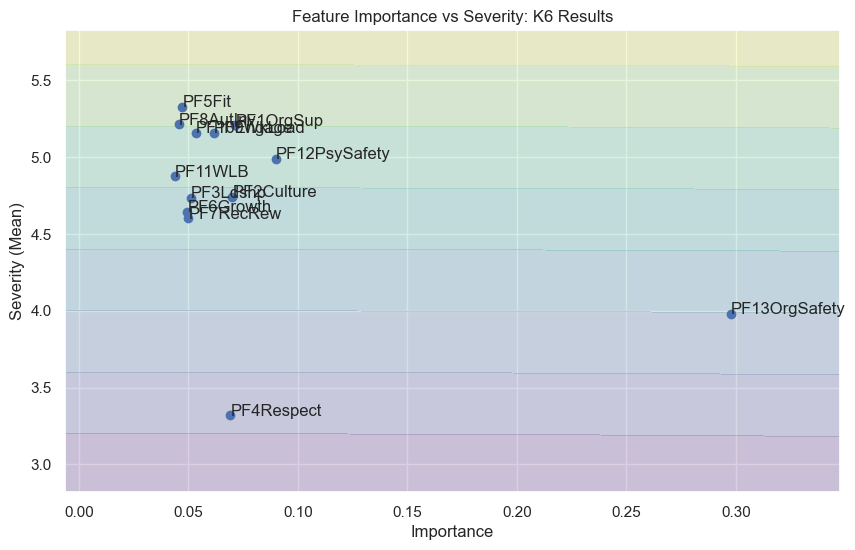

In [24]:
# Define the range for axes
x_range = np.linspace(merged_df_k6['Importance'].min() - 0.05, merged_df_k6['Importance'].max() + 0.05, 100)
y_range = np.linspace(merged_df_k6['Mean'].min() - 0.5, merged_df_k6['Mean'].max() + 0.5, 100)

# Create a meshgrid
X, Y = np.meshgrid(x_range, y_range)

# Define a function to create the heatmap values (as an example, using distance from origin)
Z = np.sqrt(X**2 + Y**2)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, alpha=0.2, cmap='viridis')  # Heatmap aspect
plt.scatter(merged_df_k6['Importance'], merged_df_k6['Mean'])

# Adding labels to each point
for i in range(merged_df_k6.shape[0]):
    plt.text(merged_df_k6['Importance'][i], merged_df_k6['Mean'][i], merged_df_k6['K6-Feature'][i])

plt.title('Feature Importance vs Severity: K6 Results')
plt.xlabel('Importance')
plt.ylabel('Severity (Mean)')
plt.grid(True)

plt.show()

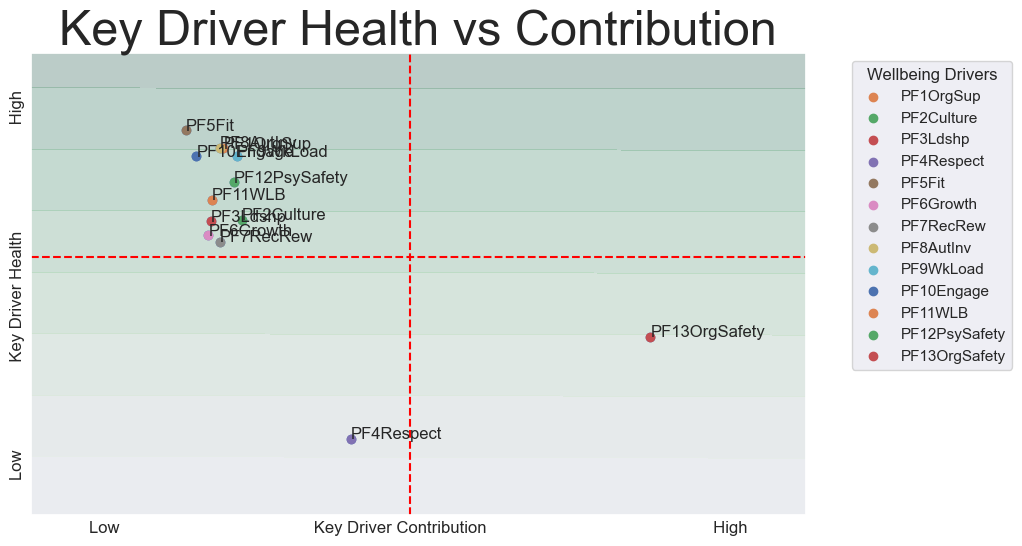

In [25]:
# Define the range for axes
x_range = np.linspace(merged_df_dass['Importance'].min() - 0.05, merged_df_dass['Importance'].max() + 0.05, 100)
y_range = np.linspace(merged_df_dass['Mean'].min() - 0.5, merged_df_dass['Mean'].max() + 0.5, 100)

# Create a meshgrid
X, Y = np.meshgrid(x_range, y_range)

# Define a function to create the heatmap values (as an example, using distance from origin)
Z = np.sqrt(X**2 + Y**2)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, alpha=0.2, cmap='Greens')  # Heatmap aspect
plt.scatter(merged_df_dass['Importance'], merged_df_dass['Mean'])

# Adding labels to each point
for i in range(merged_df_dass.shape[0]):
    plt.scatter(merged_df_dass['Importance'][i], merged_df_dass['Mean'][i], label=merged_df_dass['DASS-Feature'][i])
    plt.text(merged_df_dass['Importance'][i], merged_df_dass['Mean'][i], merged_df_dass['DASS-Feature'][i])
    
plt.axvline(x=.125, color='red', linestyle='--')
plt.axhline(y=4.5, color='red', linestyle='--')

plt.legend(title='Wellbeing Drivers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([], [])
plt.yticks([], [])

plt.title('Key Driver Health vs Contribution', fontsize = 35) 
plt.xlabel('Low                                          Key Driver Contribution                                                 High')
plt.ylabel('Low                   Key Driver Health                       High')
plt.grid(True)

plt.show()

Charts look fine(ish).

Obviously I'm using the DASS one.

In [26]:
merged_df_k6.to_csv('df_K6.csv', index=False)
merged_df_dass.to_csv('df_DASS.csv', index=False)

# Cronbach's Alpha

In [27]:
import pingouin as pg
#Variables for analysis, defining the structure of the scales being used
columns_to_analyze = {
    'PF1OrgSup': ['@PF1_OrgSup_1', '@PF1_OrgSup_2', '@PF1_OrgSup_3'],
    'PF2Culture': ['@PF2_Cult_1', '@PF2_Cult_2', '@PF2_Cult_3'],
    'PF3Ldshp': ['@PF3_Ldshp_1', '@PF3_Ldshp_2', '@PF3_Ldshp_3'],
    'PF4Respect': ['@PF4_Respect_1', '@PF4_Respect_2', '@PF4_Respect_3'],
    'PF5Fit': ['@PF5_Fit_1', '@PF5_Fit_2', '@PF5_Fit_3'],
    'PF6Growth': ['@PF6_Growth_1', '@PF6_Growth_2', '@PF6_Growth_3'],
    'PF7RecRew': ['@PF7_RecRew_1', '@PF7_RecRew_2', '@PF7_RecRew_3'],
    'PF8AutInv': ['@PF8_AutInv_1', '@PF8_AutInv_2', '@PF8_AutInv_3'],
    'PF9WkLoad': ['@PF9_WkLoad_1', '@PF9_WkLoad_2', '@PF9_WkLoad_3'],
    'PF10Engage': ['@PF10_Engage_1', '@PF10_Engage_2', '@PF10_Engage_3'],
    'PF11WLB': ['@PF11_WLB_1', '@PF11_WLB_2', '@PF11_WLB_3'],
    'PF12PsySafety': ['@PF12_PsySafety_1', '@PF12_PsySafety_2', '@PF12_PsySafety_3'],
    'PF13OrgSafety': ['@PF13_OrgSafety_1', '@PF13_OrgSafety_2', '@PF13_OrgSafety_3'],
    'K6': ['@14_K6_1', '@14_K6_2', '@14_K6_3', '@14_K6_4', '@14_K6_5', '@14_K6_6'],
    'DASS': ['@14_DASS_1', '@14_DASS_2', '@14_DASS_3', '@14_DASS_4', '@14_DASS_5', '@14_DASS_6', '@14_DASS_7']
}

In [28]:
alpha_values = {}
for scale, items in columns_to_analyze.items():
    data = df[items]
    alpha = pg.cronbach_alpha(data=data)
    alpha_values[scale] = alpha[0]

# Display the results
for scale, alpha in alpha_values.items():
    print(f"Cronbach's alpha for {scale}: {alpha}")

Cronbach's alpha for PF1OrgSup: 0.8772831054681028
Cronbach's alpha for PF2Culture: 0.9101571168612137
Cronbach's alpha for PF3Ldshp: 0.913089862837048
Cronbach's alpha for PF4Respect: 0.8759173025285187
Cronbach's alpha for PF5Fit: 0.9066936066169314
Cronbach's alpha for PF6Growth: 0.9321974603624483
Cronbach's alpha for PF7RecRew: 0.8712831746912181
Cronbach's alpha for PF8AutInv: 0.8300966564534685
Cronbach's alpha for PF9WkLoad: 0.8535249175725116
Cronbach's alpha for PF10Engage: 0.8824326476684504
Cronbach's alpha for PF11WLB: 0.9147149359130846
Cronbach's alpha for PF12PsySafety: 0.8219759869180269
Cronbach's alpha for PF13OrgSafety: 0.9021249710739322
Cronbach's alpha for K6: 0.8974682320935249
Cronbach's alpha for DASS: 0.9193693970591538


Conclusion:
- All scales are at least very good (> .80), with the majority being excellent (> .90)

# Grouped Means & ANOVA - Means by Location for Later Charts

In [31]:
for scale, items in columns_to_analyze.items():
    df[scale] = df[items].mean(axis=1)

# Group by OrgID and calculate the mean for each scale
grouped_means = df.groupby('OrgID')[list(columns_to_analyze.keys())].mean()

# Display the results
grouped_means# Creating a new DataFrame with only 'K6' and 'DASS' columns
outcome_means = grouped_means[['K6', 'DASS']]

In [32]:
# Creating a new DataFrame with only 'K6' and 'DASS' columns
outcome_means = grouped_means[['K6', 'DASS']]

# Dropping 'K6' and 'DASS' columns from the original DataFrame
grouped_means = grouped_means.drop(columns=['K6', 'DASS'])

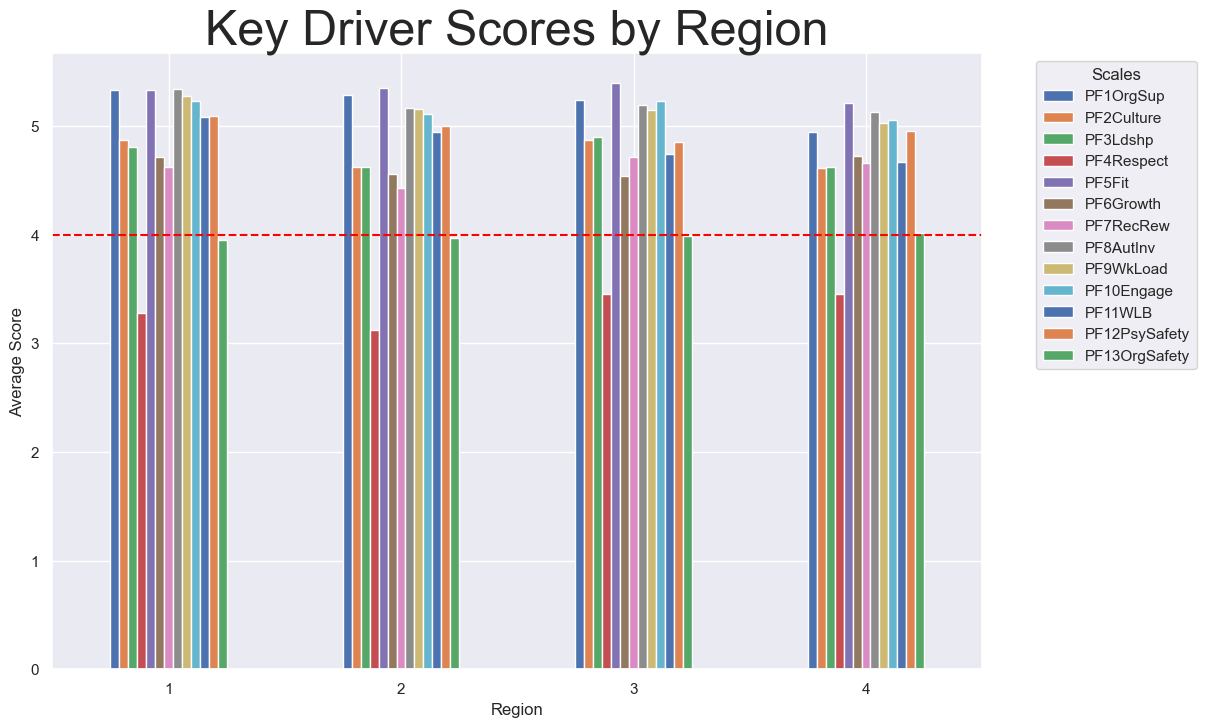

In [33]:
# Assuming grouped_means is your DataFrame and you have already created the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the bar chart
grouped_means.plot(kind='bar', ax=ax)
plt.title('Key Driver Scores by Region', fontsize=35)
plt.xlabel('Region')
plt.ylabel('Average Score')
plt.legend(title='Scales', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Adding a horizontal line
plt.axhline(y=4, color='red', linestyle='--')

# Show the plot
plt.show()

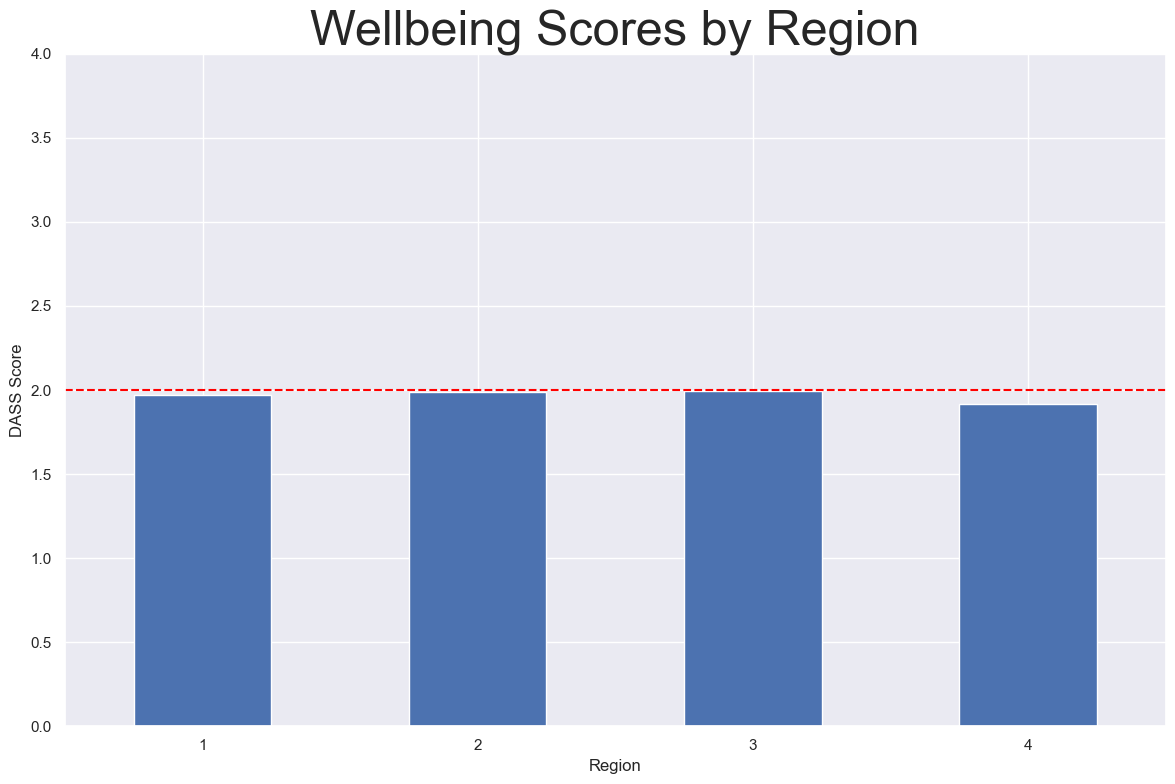

In [34]:
outcome_means['DASS'].plot(kind='bar', figsize=(12, 8))
plt.title('Wellbeing Scores by Region', fontsize =35)
plt.xlabel('Region')
plt.ylabel('DASS Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.ylim(0, 4)

plt.axhline(y=2, color='red', linestyle='--')

# Show the plot
plt.show()

In [35]:
grouped_means.to_csv('df_location_means.csv', index=False)
outcome_means.to_csv('df_outcome_means.csv', index=False)

## ANOVA

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [37]:
dependent_vars = [
    'PF1OrgSup', 'PF2Culture', 'PF3Ldshp', 'PF4Respect', 'PF5Fit', 
    'PF6Growth', 'PF7RecRew', 'PF8AutInv', 'PF9WkLoad', 'PF10Engage', 
    'PF11WLB', 'PF12PsySafety', 'PF13OrgSafety', 'K6', 'DASS'
]

# Run ANOVA for each dependent variable
anova_results = {}
for var in dependent_vars:
    formula = f'{var} ~ C(OrgID)'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[var] = anova_table

# Print the ANOVA results
for var, table in anova_results.items():
    print(f'ANOVA results for {var}:\n')
    print(table)
    print('\n' + '-'*80 + '\n')

ANOVA results for PF1OrgSup:

               sum_sq      df         F    PR(>F)
C(OrgID)    30.005358     3.0  7.523249  0.000054
Residual  1722.967634  1296.0       NaN       NaN

--------------------------------------------------------------------------------

ANOVA results for PF2Culture:

               sum_sq      df         F    PR(>F)
C(OrgID)    19.996135     3.0  3.011347  0.029209
Residual  2868.593608  1296.0       NaN       NaN

--------------------------------------------------------------------------------

ANOVA results for PF3Ldshp:

               sum_sq      df         F   PR(>F)
C(OrgID)    17.670333     3.0  3.166767  0.02366
Residual  2410.528898  1296.0       NaN      NaN

--------------------------------------------------------------------------------

ANOVA results for PF4Respect:

               sum_sq      df         F   PR(>F)
C(OrgID)    25.031272     3.0  3.509944  0.01482
Residual  3080.821292  1296.0       NaN      NaN

-----------------------------------

## Summary of Results:
Significant Results (PR(>F) < 0.05):
- PF1OrgSup: Significant difference between groups (p < 0.0001).
- PF2Culture: Significant difference between groups (p = 0.029).
- PF3Ldshp: Significant difference between groups (p = 0.024).
- PF4Respect: Significant difference between groups (p = 0.015).
- PF11WLB: Significant difference between groups (p = 0.001).
- K6: Significant difference between groups (p = 0.010).

Non-Significant Results (PR(>F) ≥ 0.05):
- PF5Fit, PF6Growth, PF7RecRew, PF8AutInv, PF9WkLoad, PF10Engage, PF12PsySafety, PF13OrgSafety, DASS.
- No significant differences between these variables by location.